In [4]:
!pip install lifelines
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.9 MB/s eta 0:00:00


In [5]:
# imports
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LassoCV, ElasticNet
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, recall_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import optuna
from sklearn.model_selection import GridSearchCV


Importing the data and pre-processing

In [6]:
df = pd.read_csv("/content/UROMOL_TaLG.teachingcohort.csv")
first_column = df.columns[0]
df = df.drop([first_column], axis=1)

# drop columns without target featurre
df = df.dropna(subset=["Recurrence", "RFS_time"])

# Define target variable based on recurrence status
df["risk_group"] = "Low"
df.loc[df["Recurrence"] == 1, "risk_group"] = pd.qcut(
    df.loc[df["Recurrence"] == 1, "RFS_time"],
    q=[0, 0.5, 1],
    labels=["Low", "High"]
)

In [7]:
# removing all columns with only one value
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_cols)

In [8]:
# Drop unnecessary columns (e.g., patient IDs)
df = df.drop(columns=["UROMOL.ID", "Progression", "PFS_time."], errors="ignore")

# Separate features and target
y = df["risk_group"]
X = df.drop(columns=["risk_group", "RFS_time", "Recurrence"])  # Features # Target

In [9]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown="ignore")
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))

X_encoded = pd.DataFrame(
    encoder.fit_transform(X[categorical_cols]).toarray(),
    columns=encoder.get_feature_names_out(categorical_cols)
)
X_encoded.index = X.index

X_encoded = X_encoded.rename(columns={
    'Tumor.size_< 3 cm': 'Tumor.size_less_three',
    'Tumor.size_>= 3 cm': 'Tumor.size_more_three'
})

# Combine encoded categorical and numerical features
X_processed = pd.concat([X_encoded, df[numerical_cols]], axis=1)

In [11]:
# KNN Imputation for missing values
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_processed)
X_processed_imputed = pd.DataFrame(X_imputed, columns=X_processed.columns)

Checking for missing values after imputation

In [12]:
na_count = X_processed_imputed.isna().any(axis=1).sum()
print(na_count)

0


In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_processed_imputed, y_encoded, test_size=0.2, random_state=42, stratify=y)

## Lasso Regression

In [38]:
# for optuna
def objective(trial):
    # Suggesting parameters for LogisticRegression
    C = trial.suggest_loguniform("C", 1e-5, 10)
    # Using 'l1' or 'l2' based on Elastic Net concept
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

    # Suggest solver separately, considering all options
    solver = trial.suggest_categorical("solver", ["saga", "liblinear", "lbfgs", "newton-cg", "sag"])

    # Filter solver based on penalty if needed within model creation
    if penalty == "l1" and solver not in ["saga", "liblinear"]:
        solver = "saga"  # Default to 'saga' if 'l1' and solver is incompatible

    # Create and evaluate LogisticRegression model
    logistic_reg = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=43, max_iter=1000)
    score = cross_val_score(logistic_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params = study.best_params

# Create and train LogisticRegression with best parameters
logistic_reg = LogisticRegression(**best_params, random_state=43, max_iter=1000)  # Increased max_iter
logistic_reg.fit(X_train, y_train)

# Make predictions
y_pred_lasso = logistic_reg.predict(X_test)
y_pred_lasso_proba = logistic_reg.predict_proba(X_test) # Now you can get probabilities

[I 2025-03-28 18:55:28,796] A new study created in memory with name: no-name-ad30ff14-214f-412b-b87c-ec72585736d4
<ipython-input-38-d40afa9b8308>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 10)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: C

## Elastic Net

In [37]:
def custom_f1(y_true, y_pred):
    """ Custom F1 score prioritizing sensitivity (recall). """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

    # Calculate precision and sensitivity (recall) per class
    precision = np.diag(cm) / np.sum(cm, axis=0, where=np.sum(cm, axis=0) > 0, initial=1)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1, where=np.sum(cm, axis=1) > 0, initial=1)

    # Compute weighted F1 score (avoiding division by zero)
    f1_weighted = (2 * sensitivity * precision) / (sensitivity + precision + 1e-10)

    # Apply custom weighting (70% sensitivity, 30% precision)
    f1_modified = np.nanmean(0.7 * sensitivity + 0.3 * precision)

    return f1_modified

In [19]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install lifelines
!pip install optuna
# %%
# imports
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LassoCV, ElasticNet, LogisticRegression # Import LogisticRegression for classification
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, recall_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import optuna
from sklearn.model_selection import GridSearchCV

def objective(trial):
    # Suggesting parameters for LogisticRegression
    C = trial.suggest_loguniform("C", 1e-5, 10)
    # Using 'l1' or 'l2' based on Elastic Net concept
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

    # Suggest solver separately, considering all options
    solver = trial.suggest_categorical("solver", ["saga", "liblinear", "lbfgs", "newton-cg", "sag"])

    # Filter solver based on penalty if needed within model creation
    if penalty == "l1" and solver not in ["saga", "liblinear"]:
        solver = "saga"  # Default to 'saga' if 'l1' and solver is incompatible

    # Create and evaluate LogisticRegression model
    logistic_reg = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=43, max_iter=1000)
    score = cross_val_score(logistic_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params = study.best_params

# Create and train LogisticRegression with best parameters
logistic_reg = LogisticRegression(**best_params, random_state=43, max_iter=1000)  # Increased max_iter
logistic_reg.fit(X_train, y_train)

# Make predictions
y_pred_en = logistic_reg.predict(X_test)
y_pred_en_proba = logistic_reg.predict_proba(X_test) # Now you can get probabilities

[I 2025-03-28 17:56:20,148] A new study created in memory with name: no-name-f2316271-3643-49ef-99db-1e055eaa6f97
<ipython-input-19-23b7de4a6fa9>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 10)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: 

## Random Forest

In [23]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=43,
        n_jobs=-1
    )

    score = cross_val_score(random_forest, X_train, y_train, cv=5, scoring="accuracy").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params = study.best_params
random_forest = RandomForestClassifier(**best_params, random_state=43, n_jobs=-1)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)
y_pred_rf_proba = random_forest.predict_proba(X_test)

[I 2025-03-28 18:04:28,390] A new study created in memory with name: no-name-e3fa3a88-125b-4f33-975e-572af779b5fb
[I 2025-03-28 18:04:29,503] Trial 0 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 79, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2025-03-28 18:04:30,577] Trial 1 finished with value: 0.6272727272727272 and parameters: {'n_estimators': 78, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2025-03-28 18:05:23,720] Trial 2 finished with value: 0.6227272727272728 and parameters: {'n_estimators': 252, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.6363636363636364.
[I 2025-03-28 18:05:29,409] Trial 3 finished with value: 0.6681818181818182 and parameters: {'n_estimators': 364, 'max_depth': 14, 'min_s

## GBM

In [24]:
def objective_gbm(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    gbm = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=43
    )

    score = cross_val_score(gbm, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

study_gbm = optuna.create_study(direction="maximize")
study_gbm.optimize(objective_gbm, n_trials=15)

best_params_gbm = study_gbm.best_params
gbm = GradientBoostingClassifier(**best_params_gbm, random_state=43)
gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)
y_pred_gbm_proba = gbm.predict_proba(X_test)

[I 2025-03-28 18:09:08,260] A new study created in memory with name: no-name-a17a0d41-2574-4c25-9217-6ab42eac19bd
<ipython-input-24-631ee96a8870>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
[I 2025-03-28 18:09:13,951] Trial 0 finished with value: 0.6409090909090909 and parameters: {'n_estimators': 291, 'learning_rate': 0.012240231787144775, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6943895931062817, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6409090909090909.
<ipython-input-24-631ee96a8870>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_ra

## XGBoost

In [26]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_loguniform("gamma", 1e-8, 10.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    xgb = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=43
    )

    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring="accuracy").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params = study.best_params

xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=43)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)

[I 2025-03-28 18:17:14,913] A new study created in memory with name: no-name-d0475b7b-bee7-427e-a36d-d6a9e2ded764
<ipython-input-26-f32036615b8f>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.5)
<ipython-input-26-f32036615b8f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-8, 10.0)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWa

## Creating the ensemble

In [40]:
model_results = {
    "Lasso":         (y_pred_lasso,  y_pred_lasso_proba),
    "ElasticNet":    (y_pred_en,    y_pred_en_proba),
    "RandomForest":  (y_pred_rf,       y_pred_rf_proba),
    "GBM":           (y_pred_gbm,      y_pred_gbm_proba),
    "XGBoost":       (y_pred_xgb,      y_pred_xgb_proba)
}

performance_data = []

for model_name, (preds, scores) in model_results.items():
    # accuracy
    acc = accuracy_score(y_test, preds)

    # AUC - use probabilities for the positive class (index 1 for binary classification)
    auc_val = roc_auc_score(y_test, scores[:, 1]) # Extract probabilities of the positive class

    # sensitivity - recall for the positive class
    sens = recall_score(y_test, preds, pos_label=1)

    performance_data.append({
        'Model': model_name,
        'Accuracy': acc,
        'AUC': auc_val,
        'Sensitivity': sens
    })

perf_df = pd.DataFrame(performance_data)
print("=== Model Performance Summary ===")
display(perf_df)


model_names = perf_df['Model'].tolist()

# set up majority vote ensemble among chosen models
def ensemble_vote(models_list, model_results_dict, threshold):
    sum_preds = np.zeros_like(y_test, dtype=int)
    for m in models_list:
        sum_preds += model_results_dict[m][0]

    return (sum_preds >= threshold).astype(int)

# majority is 3 votes or more.
ensemble_sens_pred = ensemble_vote(model_names, model_results, threshold=3)

# evaluate the ensemble
def evaluate_ensemble(ensemble_name, ensemble_pred, model_names):
    print(f"\n{ensemble_name} Ensemble")
    print("Using models:", model_names)

    # Confusion Matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{ensemble_name} Ensemble Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(classification_report(y_test, ensemble_pred))

    # Approximate Probability for ROC:
    sum_preds = np.zeros_like(y_test, dtype=int)
    for m in model_names:
        sum_preds += model_results[m][0]
    ensemble_score = sum_preds / 5.0

    fpr, tpr, _ = roc_curve(y_test, ensemble_score)
    auc_val = roc_auc_score(y_test, ensemble_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{ensemble_name} (AUC={auc_val:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{ensemble_name} Ensemble ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

evaluate_ensemble("Top-5 by Sensitivity", ensemble_sens_pred, best5_sens_names)


=== Model Performance Summary ===


,Model,Accuracy,AUC,Sensitivity
0,Lasso,0.660714,0.505690,1.000000
1,ElasticNet,0.660714,0.419630,1.000000
2,RandomForest,0.678571,0.641536,1.000000
3,GBM,0.696429,0.605974,0.945946
4,XGBoost,0.660714,0.497866,1.000000


NameError: name 'best5_sens_names' is not defined

In [41]:
# Define individual models
models = {
    "EN": LogisticRegression(penalty='l2', max_iter=500),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RF": RandomForestClassifier(n_estimators=100),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

# Ensemble: Voting Classifier (Soft Voting for Confidence Scores)
ensemble = VotingClassifier(estimators=list(models.items()), voting="soft")
ensemble.fit(X_train, y_train)

# Predictions & Confidence Scores
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)  # Confidence values

y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Convert confidence scores to dictionary for better interpretation
confidence_scores = [
    {category: prob for category, prob in zip(ensemble.classes_, probs)}
    for probs in y_prob
]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

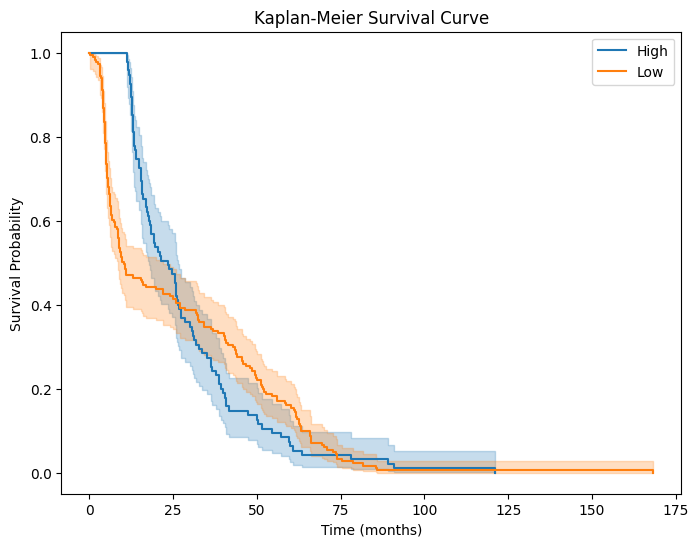

In [45]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in df['risk_group'].unique():  # Iterate through unique risk groups
    mask = df["risk_group"] == group
    # Ensure RFS_time values are numeric and handle potential errors:
    durations = pd.to_numeric(df["RFS_time"][mask], errors='coerce').dropna()

    # Similarly, ensure event_observed is numeric and aligned with durations:
    event_observed = (df["risk_group"][mask] != 0).astype(int).loc[durations.index]

    if len(durations) > 0:  # Check if there are any valid durations for this group
        kmf.fit(durations, event_observed=event_observed, label=group)
        kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

Confusion Matrix:
 [[ 3 16]
 [ 4 33]]

Classification Report:
               precision    recall  f1-score   support

        High       0.43      0.16      0.23        19
         Low       0.67      0.89      0.77        37

    accuracy                           0.64        56
   macro avg       0.55      0.52      0.50        56
weighted avg       0.59      0.64      0.59        56

ROC-AUC Score: 0.5120910384068279


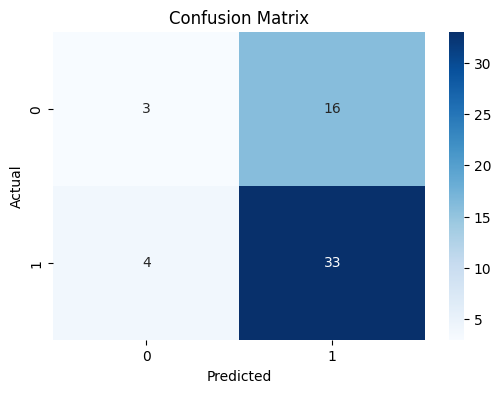

In [46]:
# Evaluate Performance
print("Confusion Matrix:\n", confusion_matrix(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))
print("ROC-AUC Score:", roc_auc_score(pd.get_dummies(y_test_decoded), y_prob, multi_class="ovr"))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_decoded, y_pred_decoded), annot=True, fmt="d", cmap="Blues", xticklabels=ensemble.classes_, yticklabels=ensemble.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [47]:
# Save Model
with open("ensemblemodel.pkl", "wb") as f:
    pickle.dump(ensemble, f)

# Example Output: First 5 Predictions with Confidence Scores
for i in range(5):
    print(f"Prediction: {y_pred[i]}, Confidence Scores: {confidence_scores[i]}")

Prediction: 1, Confidence Scores: {np.int64(0): np.float64(0.3720016150046538), np.int64(1): np.float64(0.6279983849953462)}
Prediction: 1, Confidence Scores: {np.int64(0): np.float64(0.37278499645914065), np.int64(1): np.float64(0.6272150095013238)}
Prediction: 1, Confidence Scores: {np.int64(0): np.float64(0.2952021581007989), np.int64(1): np.float64(0.7047978418992011)}
Prediction: 0, Confidence Scores: {np.int64(0): np.float64(0.5824439120048485), np.int64(1): np.float64(0.417556082034687)}
Prediction: 1, Confidence Scores: {np.int64(0): np.float64(0.28163697862550524), np.int64(1): np.float64(0.7183630213744947)}
